In [1]:
# run this for all imports necessary
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssm

#### read in all files, transform and normalize (clamp between 0.0 and 1.0)

In [2]:
classes = os.listdir('./data/processed/train')
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

train = test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir('./data/processed/train/'):
    for faces in os.listdir('./data/processed/train/'+c):
        img = np.array(Image.open('./data/processed/train/'+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir('./data/processed/test/'):
    for faces in os.listdir('./data/processed/test/'+c):
        img = np.array(Image.open('./data/processed/test/'+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

train_x = train_x/255
test_x = test_x/255

### define util methods

In [3]:
def reshape_img(img):
    return np.reshape(img, (112, 92))

def add_gaussian_noise(img, var):
    mean = 0
    std = var ** 0.5
    noise = np.random.normal(mean, std, img.shape)
    img = img + noise
    return img

def add_binomial_noise(img, corruption_level):
    rand = np.random.random(img.shape)
    rand = rand >= corruption_level
    new = np.zeros(img.shape)
    new[rand] += img[rand]
    return new

def add_noise(imgs, noise_type, param):
    noised_imgs = []
    if (noise_type=="gaussian"):
        for img in imgs:
            noised_imgs.append(add_gaussian_noise(reshape_img(img), param))
    else:
        for img in imgs:
            noised_imgs.append(add_binomial_noise(reshape_img(img), param))
    return noised_imgs

def show_imgs(img1, img2):
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(reshape_img(img1), cmap='gray')

    fig.add_subplot(1, 2, 2)
    plt.imshow(reshape_img(img2), cmap='gray')
    plt.show()

### define NNs
_according to paper:_
- first DAE layer:
    - |imgsize| visable layers
    - 1000 hidden layers
    - encode with tanh activation
    - decode with linear (none) activation
- second DAE layer:
    - 1000 visable layers????
    - 300 hidden layers
    - encode with tanh activation
    - decode with linear (none) activation
- softmax layer:
    - |imgsize| input layers
    - |classes| output layers
    - linear function with softmax "activation"

In [4]:
class DAE1(torch.nn.Module):
    def __init__(self, size):
        super(DAE1, self).__init__()
        self.encode = torch.nn.Linear(size, 1000)
        self.decode = torch.nn.Linear(1000, size)
        
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        
        x = torch.tanh(self.encode(x))
        x = self.decode(x)
        return x
 
    
class DAE2(torch.nn.Module):
    def __init__(self, size):
        super(DAE2, self).__init__()
        self.encode = torch.nn.Linear(size, 300)
        self.decode = torch.nn.Linear(300, size)
        
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        
        x = torch.tanh(self.encode(x))
        x = self.decode(x)
        return x

class SoftMaxModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(SoftMaxModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(D_in, D_out)
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = F.log_softmax(self.linear1(x), dim=1)
        return x

In [5]:
input_1 = train_x

### add (gaussian or binomial) noise to images

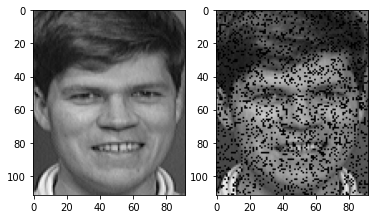

In [6]:
noised_1 = add_noise(input_1, "binomial", 0.2)
# noised_imgs = add_noise(train_x, "gaussian", 0.005)

img_nr = 10
show_imgs(input_1[img_nr], noised_1[img_nr])

### first DAE layer:
_according to paper:_
- max 5000 epochs
- learning rate 1e-5 (1e-4 works better)
- loss: Mean Sqared Recreational Error
- Stochastic Gradient Descend (doesn't work, but Adam optimizer does)
- weight initialization range should be -0.5 - 0.5 (¡not implemented!)

In [7]:
# train first dae with 1000 hidden nodes
model_1 = DAE1(len(input_1[0]))

epochs = 5000
lr = 1e-4

#weight initialisation range??? should be -0.05 - 0.05

### tanh+linear, mse, adam, binom noise=0.2, loss=0.002190

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr) #SGD

for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = model_1(torch.Tensor(noised_1))
    loss = criterion(y_hat, torch.Tensor(input_1))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

Epoch: 0 	Training Loss: 0.252545
Epoch: 1 	Training Loss: 0.231718
Epoch: 2 	Training Loss: 0.211982
Epoch: 3 	Training Loss: 0.194486
Epoch: 4 	Training Loss: 0.176935
Epoch: 5 	Training Loss: 0.156911
Epoch: 6 	Training Loss: 0.136614
Epoch: 7 	Training Loss: 0.117947
Epoch: 8 	Training Loss: 0.101288
Epoch: 9 	Training Loss: 0.086387
Epoch: 10 	Training Loss: 0.073290
Epoch: 11 	Training Loss: 0.062263
Epoch: 12 	Training Loss: 0.053402
Epoch: 13 	Training Loss: 0.046534
Epoch: 14 	Training Loss: 0.041381
Epoch: 15 	Training Loss: 0.037634
Epoch: 16 	Training Loss: 0.034956
Epoch: 17 	Training Loss: 0.033041
Epoch: 18 	Training Loss: 0.031678
Epoch: 19 	Training Loss: 0.030729
Epoch: 20 	Training Loss: 0.030061
Epoch: 21 	Training Loss: 0.029544
Epoch: 22 	Training Loss: 0.029087
Epoch: 23 	Training Loss: 0.028635
Epoch: 24 	Training Loss: 0.028169
Epoch: 25 	Training Loss: 0.027716
Epoch: 26 	Training Loss: 0.027286
Epoch: 27 	Training Loss: 0.026851
Epoch: 28 	Training Loss: 0.02

In [8]:
# tested with lr=1e-5, 5000 epochs --> loss=0.002837
# tested with lr=1e-4, 5000 epochs --> loss=0.000060
output_1 = model_1(torch.Tensor(input_1))

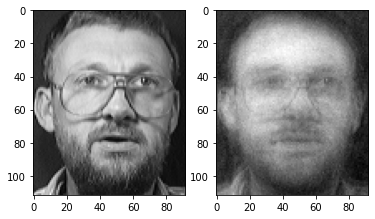

In [9]:
# evaluate reconstructed img
img_nr = 239

train_img = torch.Tensor(input_1)[img_nr].view(112,92)
rec_img = output_1[img_nr].view(112,92).detach().numpy()

show_imgs(train_img, rec_img)

In [10]:
# save first model
torch.save(model_1.state_dict(), 'models/dae_1000.pt')

In [11]:
input_2 = output_1.detach().numpy()

### add gaussian or binomial noise to images

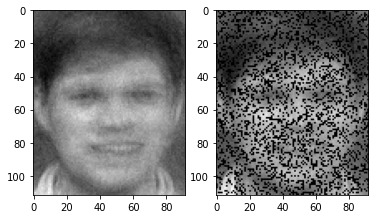

In [12]:
noised_2 = add_noise(input_2, 'binomial', 0.3)

img_nr = 10
show_imgs(input_2[img_nr], noised_2[img_nr])

### second DAE layer:
_according to paper:_
- max 500 epochs
- learning rate 1e-5 (1e-4 works better)
- loss: Mean Sqared Recreational Error
- Stochastic Gradient Descend (doesn't work, but Adam optimizer does)
- weight initialization range should be -0.5 - 0.5 (¡not implemented!)

In [26]:
model_2 = DAE2(len(input_2[0]))

epochs = 5000
lr = 1e-4

#weight initialisation range??? should be -0.05 - 0.05

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = model_2(torch.Tensor(noised_2))
    loss = criterion(y_hat, torch.Tensor(input_2))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

Epoch: 0 	Training Loss: 0.320282
Epoch: 1 	Training Loss: 0.313097
Epoch: 2 	Training Loss: 0.304093
Epoch: 3 	Training Loss: 0.299538
Epoch: 4 	Training Loss: 0.296164
Epoch: 5 	Training Loss: 0.289524
Epoch: 6 	Training Loss: 0.281518
Epoch: 7 	Training Loss: 0.274076
Epoch: 8 	Training Loss: 0.267419
Epoch: 9 	Training Loss: 0.260567
Epoch: 10 	Training Loss: 0.252610
Epoch: 11 	Training Loss: 0.243613
Epoch: 12 	Training Loss: 0.234324
Epoch: 13 	Training Loss: 0.225259
Epoch: 14 	Training Loss: 0.216333
Epoch: 15 	Training Loss: 0.207233
Epoch: 16 	Training Loss: 0.197859
Epoch: 17 	Training Loss: 0.188356
Epoch: 18 	Training Loss: 0.178916
Epoch: 19 	Training Loss: 0.169644
Epoch: 20 	Training Loss: 0.160547
Epoch: 21 	Training Loss: 0.151619
Epoch: 22 	Training Loss: 0.142889
Epoch: 23 	Training Loss: 0.134415
Epoch: 24 	Training Loss: 0.126248
Epoch: 25 	Training Loss: 0.118411
Epoch: 26 	Training Loss: 0.110910
Epoch: 27 	Training Loss: 0.103749
Epoch: 28 	Training Loss: 0.09

In [27]:
# (model_1: lr=1e-5) lr=1e-4, 500 epochs --> loss = 0.006528
# (model_1: lr=1e-5) lr=1e-4, 1000 epochs --> loss = 0.003325

# (model_1: lr=1e-4) lr=1e-5, 1000 epochs --> loss = 0.016365
# (model_1: lr=1e-4) lr=1e-4, 1000 epochs --> loss = 0.003216
# (model_1: lr=1e-4) lr=1e-4, 5000 epochs --> loss = 0.000543

output_2 = model_2(torch.Tensor(input_2))

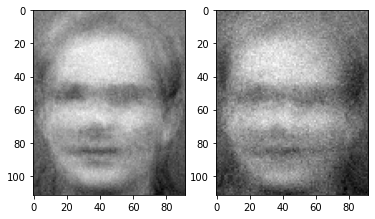

In [29]:
# evaluate reconstructed img
img_nr = 139

train_img = torch.Tensor(input_2)[img_nr].view(112,92)
rec_img = output_2[img_nr].view(112,92).detach().numpy()

show_imgs(train_img, rec_img)

In [30]:
# save second model
torch.save(model_2.state_dict(), 'models/dae_300.pt')

In [31]:
input_3 = output_2.detach().numpy()

### Softmax layer:
_according to paper:_
- max 1000 epochs
- learning rate 1e-2
- loss: probably CrossEntropy (not 100% sure)
- Stochastic Gradient Descend
- weight initialization range should be -0.005 - 0.005 i think (¡not implemented!)

In [36]:
model_3 = SoftMaxModel(len(input_3[0]), len(classes))
    
epochs = 5000
lr = 1e-2

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = model_3(torch.Tensor(input_3))
    loss = criterion(y_hat, torch.LongTensor(train_y))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

Epoch: 0 	Training Loss: 3.755323
Epoch: 1 	Training Loss: 3.655113
Epoch: 2 	Training Loss: 3.609107
Epoch: 3 	Training Loss: 3.572709
Epoch: 4 	Training Loss: 3.538392
Epoch: 5 	Training Loss: 3.504882
Epoch: 6 	Training Loss: 3.472140
Epoch: 7 	Training Loss: 3.440139
Epoch: 8 	Training Loss: 3.408860
Epoch: 9 	Training Loss: 3.378273
Epoch: 10 	Training Loss: 3.348354
Epoch: 11 	Training Loss: 3.319081
Epoch: 12 	Training Loss: 3.290435
Epoch: 13 	Training Loss: 3.262389
Epoch: 14 	Training Loss: 3.234928
Epoch: 15 	Training Loss: 3.208025
Epoch: 16 	Training Loss: 3.181668
Epoch: 17 	Training Loss: 3.155839
Epoch: 18 	Training Loss: 3.130513
Epoch: 19 	Training Loss: 3.105683
Epoch: 20 	Training Loss: 3.081327
Epoch: 21 	Training Loss: 3.057429
Epoch: 22 	Training Loss: 3.033979
Epoch: 23 	Training Loss: 3.010962
Epoch: 24 	Training Loss: 2.988362
Epoch: 25 	Training Loss: 2.966170
Epoch: 26 	Training Loss: 2.944371
Epoch: 27 	Training Loss: 2.922955
Epoch: 28 	Training Loss: 2.90

### evaluate accuracy

In [38]:
correct = 0
total = 0
for i in range(len(train_y)):
    if(train_y[i] == y_hat[i].argmax()):
        correct += 1
    total += 1
print(f'Accuracy: {correct/total*100}%')

Accuracy: 100.0%


- try 1:
    - dae1: lr=1e-5, 5000 epochs
    - dae2: lr=1e-5, 500 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 26,7857%
- try 2:
    - dae1: lr=1e-5, 5000 epochs
    - dae2: lr=1e-4, 500 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 79,6428%
- try 3:
    - dae1: lr=1e-5, 5000 epochs
    - dae2: lr=1e-4, 1000 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 92.1428%
- try 4:
    - dae1: lr=1e-4, 5000 epochs
    - dae2: lr=1e-4, 1000 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 93.5714%
- try 5:
    - dae1: lr=1e-4, 5000 epochs
    - dae2: lr=1e-4, 5000 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 96.7857%
- try 6:
    - dae1: lr=1e-4, 5000 epochs
    - dae2: lr=1e-4, 5000 epochs
    - softmax: lr=1e-2, 3000 epochs
    - acc = 98.9285%
- try 7:
    - dae1: lr=1e-4, 5000 epochs
    - dae2: lr=1e-4, 5000 epochs
    - softmax: lr=1e-2, 5000 epochs
    - acc = 100.0000%